Adapted from DARIEN SCHETTLER's inference notebook.

In [1]:
# Cell Segmentator Tool
print("\n... INSTALLING AND IMPORTING CELL-PROFILER TOOL (HPACELLSEG) ...\n")
try:
    import hpacellseg.cellsegmentator as cellsegmentator
    from hpacellseg.utils import label_cell
except:
    !pip install -q "/kaggle/input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl"
    !pip install -q "/kaggle/input/hpapytorchzoozip/pytorch_zoo-master"
    !pip install -q "/kaggle/input/hpacellsegmentatormaster/HPA-Cell-Segmentation-master"
    import hpacellseg.cellsegmentator as cellsegmentator
    from hpacellseg.utils import label_cell

print("\n... OTHER IMPORTS STARTING ...\n")
print("\n\tVERSION INFORMATION")

# Machine Learning and Data Science Imports
import tensorflow as tf; print(f"\t\t– TENSORFLOW VERSION: {tf.__version__}");
import pandas as pd; pd.options.mode.chained_assignment = None;
import numpy as np; print(f"\t\t– NUMPY VERSION: {np.__version__}");
import torch

# Built In Imports
from collections import Counter
from datetime import datetime
import multiprocessing
from glob import glob
import warnings
import requests
import imageio
import IPython
import urllib
import zipfile
import pickle
import random
import shutil
import string
import math
import tqdm
import time
import gzip
import sys
import ast
import csv; csv.field_size_limit(sys.maxsize)
import io
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib; print(f"\t\t– MATPLOTLIB VERSION: {matplotlib.__version__}");
import plotly
import PIL
import cv2

# Submission Imports
from pycocotools import _mask as coco_mask
from pycocotools import mask as mutils
import typing as t
import base64
import zlib

# PRESETS
LBL_NAMES = ["Nucleoplasm", "Nuclear Membrane", "Nucleoli", "Nucleoli Fibrillar Center", "Nuclear Speckles", "Nuclear Bodies", "Endoplasmic Reticulum", "Golgi Apparatus", "Intermediate Filaments", "Actin Filaments", "Microtubules", "Mitotic Spindle", "Centrosome", "Plasma Membrane", "Mitochondria", "Aggresome", "Cytosol", "Vesicles", "Negative"]
INT_2_STR = {x:LBL_NAMES[x] for x in np.arange(19)}
INT_2_STR_LOWER = {k:v.lower().replace(" ", "_") for k,v in INT_2_STR.items()}
STR_2_INT_LOWER = {v:k for k,v in INT_2_STR_LOWER.items()}
STR_2_INT = {v:k for k,v in INT_2_STR.items()}
FIG_FONT = dict(family="Helvetica, Arial", size=14, color="#7f7f7f")
LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", len(LBL_NAMES))]
LABEL_COL_MAP = {str(i):x for i,x in enumerate(LABEL_COLORS)}

print("\n\n... IMPORTS COMPLETE ...\n")

# Stop Tensorflow From Eating All The Memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "... Physical GPUs,", len(logical_gpus), "Logical GPUs ...\n")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


... INSTALLING AND IMPORTING CELL-PROFILER TOOL (HPACELLSEG) ...


... OTHER IMPORTS STARTING ...


	VERSION INFORMATION
		– TENSORFLOW VERSION: 2.4.0
		– NUMPY VERSION: 1.19.5
		– MATPLOTLIB VERSION: 3.3.3


... IMPORTS COMPLETE ...

1 ... Physical GPUs, 1 Logical GPUs ...



In [2]:
! cp -r /kaggle/input/kgl-humanprotein-data/kgl_humanprotein_data /
! cp -r /kaggle/input/humanpro/kgl_humanprotein /

sys.path.append('/kgl_humanprotein')
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F

from kgl_humanprotein.utils.augment_util import *
from kgl_humanprotein.utils.common_util import *
from kgl_humanprotein.networks.imageclsnet import init_network

run on 53f1839160a0


In [3]:
# Define paths to nucleus and cell models for the cellsegmentator class
NUC_MODEL = '/kaggle/input/hpacellsegmentatormodelweights/dpn_unet_nuclei_v1.pth'
CELL_MODEL = '/kaggle/input/hpacellsegmentatormodelweights/dpn_unet_cell_3ch_v1.pth'

B2_CELL_CLSFR_DIR = "/kaggle/input/hpa-cellwise-classification-training/ebnet_b2_wdensehead/ckpt-0007-0.0901.ckpt"

# Define the path to the competition data directory
DATA_DIR = "/kaggle/input/hpa-single-cell-image-classification"

# Define the paths to the training and testing tfrecord and 
# image folders respectively for the competition data
TEST_IMG_DIR = os.path.join(DATA_DIR, "test")

# Capture all the relevant full image paths for the competition dataset
TEST_IMG_PATHS = sorted([os.path.join(TEST_IMG_DIR, f_name) for f_name in os.listdir(TEST_IMG_DIR)])
print(f"... The number of testing images is {len(TEST_IMG_PATHS)}" \
      f"\n\t--> i.e. {len(TEST_IMG_PATHS)//4} 4-channel images ...")

# Define paths to the relevant csv files
SWAP_SS_CSV = os.path.join(DATA_DIR, "sample_submission.csv")

# Create the relevant dataframe objects
ss_df = pd.read_csv(SWAP_SS_CSV)

# helps us control whether this is the full submission or just the initial pass
IS_DEMO = len(ss_df)==559

if IS_DEMO:
    ss_df_1 = ss_df.drop_duplicates("ImageWidth", keep="first")
    ss_df_2 = ss_df.drop_duplicates("ImageWidth", keep="last")
    ss_df = pd.concat([ss_df_1, ss_df_2])
    del ss_df_1; del ss_df_2; gc.collect();
    print("\n\nSAMPLE SUBMISSION DATAFRAME\n\n")
    display(ss_df)
else:
    print("\n\nSAMPLE SUBMISSION DATAFRAME\n\n")
    display(ss_df)

... The number of testing images is 2236
	--> i.e. 559 4-channel images ...


SAMPLE SUBMISSION DATAFRAME




,ID,ImageWidth,ImageHeight,PredictionString
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
4,0173029a-161d-40ef-af28-2342915b22fb,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==
6,020a29cf-2c24-478b-8603-c22a90dc3e31,1728,1728,0 1 eNoLCAjJNgIABNkBkg==
554,fea47298-266a-4cf4-93bd-55d1bcc2fc7d,1728,1728,0 1 eNoLCAjJNgIABNkBkg==
557,ff069fa2-d948-408e-91b3-034cfea428d1,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==
558,ff23eea9-4bbe-42af-a8da-9ae16321fc6d,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==


In [4]:
def binary_mask_to_ascii(mask, mask_val=1):
    """Converts a binary mask into OID challenge encoding ascii text."""
    mask = np.where(mask==mask_val, 1, 0).astype(np.bool)
    
    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError(f"encode_binary_mask expects a binary mask, received dtype == {mask.dtype}")

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(f"encode_binary_mask expects a 2d mask, received shape == {mask.shape}")

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str.decode()


def rle_encoding(img, mask_val=1):
    """
    Turns our masks into RLE encoding to easily store them
    and feed them into models later on
    https://en.wikipedia.org/wiki/Run-length_encoding
    
    Args:
        img (np.array): Segmentation array
        mask_val (int): Which value to use to create the RLE
        
    Returns:
        RLE string
    
    """
    dots = np.where(img.T.flatten() == mask_val)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
        
    return ' '.join([str(x) for x in run_lengths])


def rle_to_mask(rle_string, height, width):
    """ Convert RLE sttring into a binary mask 
    
    Args:
        rle_string (rle_string): Run length encoding containing 
            segmentation mask information
        height (int): Height of the original image the map comes from
        width (int): Width of the original image the map comes from
    
    Returns:
        Numpy array of the binary segmentation mask for a given cell
    """
    rows,cols = height,width
    rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
    rle_pairs = np.array(rle_numbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rle_pairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    return img


def decode_img(img, img_size=(224,224), testing=False):
    """TBD"""
    
    # convert the compressed string to a 3D uint8 tensor
    if not testing:
        # resize the image to the desired size
        img = tf.image.decode_png(img, channels=1)
        return tf.cast(tf.image.resize(img, img_size), tf.uint8)
    else:
        return tf.image.decode_png(img, channels=1)
        

    
def preprocess_path_ds(rp, gp, bp, yp, lbl, n_classes=19, img_size=(224,224), combine=True, drop_yellow=True):
    """ TBD """
    
    ri = decode_img(tf.io.read_file(rp), img_size)
    gi = decode_img(tf.io.read_file(gp), img_size)
    bi = decode_img(tf.io.read_file(bp), img_size)
    yi = decode_img(tf.io.read_file(yp), img_size)

    if combine and drop_yellow:
        return tf.stack([ri[..., 0], gi[..., 0], bi[..., 0]], axis=-1), tf.one_hot(lbl, n_classes, dtype=tf.uint8)
    elif combine:
        return tf.stack([ri[..., 0], gi[..., 0], bi[..., 0], yi[..., 0]], axis=-1), tf.one_hot(lbl, n_classes, dtype=tf.uint8)
    elif drop_yellow:
        return ri, gi, bi, tf.one_hot(lbl, n_classes, dtype=tf.uint8)
    else:
        return ri, gi, bi, yi, tf.one_hot(lbl, n_classes, dtype=tf.uint8)        
    
    
def create_pred_col(row):
    """ Simple function to return the correct prediction string
    
    We will want the original public test dataframe submission when it is 
    available. However, we will use the swapped inn submission dataframe
    when it is not.
    
    Args:
        row (pd.Series): A row in the dataframe
    
    Returns:
        The prediction string
    """
    if pd.isnull(row.PredictionString_y):
        return row.PredictionString_x
    else:
        return row.PredictionString_y
    
    
def load_image(img_id, img_dir, testing=False, only_public=False):
    """ Load An Image Using ID and Directory Path - Composes 4 Individual Images """
    if only_public:
        return_axis = -1
        clr_list = ["red", "green", "blue"]
    else:
        return_axis = 0
        clr_list = ["red", "green", "blue", "yellow"]
    
    if not testing:
        rgby = [
            np.asarray(Image.open(os.path.join(img_dir, img_id+f"_{c}.png")), np.uint8) \
            for c in ["red", "green", "blue", "yellow"]
        ]
        return np.stack(rgby, axis=-1)
    else:
        # This is for cellsegmentator
        return np.stack(
            [np.asarray(decode_img(tf.io.read_file(os.path.join(img_dir, img_id+f"_{c}.png")), testing=True), np.uint8)[..., 0] \
             for c in clr_list], axis=return_axis,
        )
        


def plot_rgb(arr, figsize=(12,12)):
    """ Plot 3 Channel Microscopy Image """
    plt.figure(figsize=figsize)
    plt.title(f"RGB Composite Image", fontweight="bold")
    plt.imshow(arr)
    plt.axis(False)
    plt.show()
    
    
def convert_rgby_to_rgb(arr):
    """ Convert a 4 channel (RGBY) image to a 3 channel RGB image.
    
    Advice From Competition Host/User: lnhtrang

    For annotation (by experts) and for the model, I guess we agree that individual 
    channels with full range px values are better. 
    In annotation, we toggled the channels. 
    For visualization purpose only, you can try blending the channels. 
    For example, 
        - red = red + yellow
        - green = green + yellow/2
        - blue=blue.
        
    Args:
        arr (numpy array): The RGBY, 4 channel numpy array for a given image
    
    Returns:
        RGB Image
    """
    
    rgb_arr = np.zeros_like(arr[..., :-1])
    rgb_arr[..., 0] = arr[..., 0]
    rgb_arr[..., 1] = arr[..., 1]+arr[..., 3]/2
    rgb_arr[..., 2] = arr[..., 2]
    
    return rgb_arr
    
    
def plot_ex(arr, figsize=(20,6), title=None, plot_merged=True, rgb_only=False):
    """ Plot 4 Channels Side by Side """
    if plot_merged and not rgb_only:
        n_images=5 
    elif plot_merged and rgb_only:
        n_images=4
    elif not plot_merged and rgb_only:
        n_images=4
    else:
        n_images=3
    plt.figure(figsize=figsize)
    if type(title) == str:
        plt.suptitle(title, fontsize=20, fontweight="bold")

    for i, c in enumerate(["Red Channel – Microtubles", "Green Channel – Protein of Interest", "Blue - Nucleus", "Yellow – Endoplasmic Reticulum"]):
        if not rgb_only:
            ch_arr = np.zeros_like(arr[..., :-1])        
        else:
            ch_arr = np.zeros_like(arr)
        if c in ["Red Channel – Microtubles", "Green Channel – Protein of Interest", "Blue - Nucleus"]:
            ch_arr[..., i] = arr[..., i]
        else:
            if rgb_only:
                continue
            ch_arr[..., 0] = arr[..., i]
            ch_arr[..., 1] = arr[..., i]
        plt.subplot(1,n_images,i+1)
        plt.title(f"{c.title()}", fontweight="bold")
        plt.imshow(ch_arr)
        plt.axis(False)
        
    if plot_merged:
        plt.subplot(1,n_images,n_images)
        
        if rgb_only:
            plt.title(f"Merged RGB", fontweight="bold")
            plt.imshow(arr)
        else:
            plt.title(f"Merged RGBY into RGB", fontweight="bold")
            plt.imshow(convert_rgby_to_rgb(arr))
        plt.axis(False)
        
    plt.tight_layout(rect=[0, 0.2, 1, 0.97])
    plt.show()
    
    
def flatten_list_of_lists(l_o_l, to_string=False):
    if not to_string:
        return [item for sublist in l_o_l for item in sublist]
    else:
        return [str(item) for sublist in l_o_l for item in sublist]




def get_contour_bbox_from_raw(raw_mask):
    """ Get bbox of contour as `xmin ymin xmax ymax`
    
    Args:
        raw_mask (nparray): Numpy array containing segmentation mask information
    
    Returns:
        Numpy array for a cell bounding box coordinates
    """
    cnts = grab_contours(
        cv2.findContours(
            raw_mask, 
            cv2.RETR_EXTERNAL, 
            cv2.CHAIN_APPROX_SIMPLE
        ))
    xywhs = [cv2.boundingRect(cnt) for cnt in cnts]
    xys = [(xywh[0], xywh[1], xywh[0]+xywh[2], xywh[1]+xywh[3]) for xywh in xywhs]
    return sorted(xys, key=lambda x: (x[1], x[0]))


def pad_to_square(a):
    """ Pad an array `a` evenly until it is a square """
    if a.shape[1]>a.shape[0]: # pad height
        n_to_add = a.shape[1]-a.shape[0]
        top_pad = n_to_add//2
        bottom_pad = n_to_add-top_pad
        a = np.pad(a, [(top_pad, bottom_pad), (0, 0), (0, 0)], mode='constant')

    elif a.shape[0]>a.shape[1]: # pad width
        n_to_add = a.shape[0]-a.shape[1]
        left_pad = n_to_add//2
        right_pad = n_to_add-left_pad
        a = np.pad(a, [(0, 0), (left_pad, right_pad), (0, 0)], mode='constant')
    else:
        pass
    return a



def grab_contours(cnts):
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        raise Exception(("Contours tuple must have length 2 or 3, "
            "otherwise OpenCV changed their cv2.findContours return "
            "signature yet again. Refer to OpenCV's documentation "
            "in that case"))

    # return the actual contours array
    return cnts


    
def plot_predictions(img, masks, preds, confs=None, fill_alpha=0.3, lbl_as_str=True):
    # Initialize
    FONT = cv2.FONT_HERSHEY_SIMPLEX; FONT_SCALE = 0.7; FONT_THICKNESS = 2; FONT_LINE_TYPE = cv2.LINE_AA;
    COLORS = [[round(y*255) for y in x] for x in sns.color_palette("Spectral", len(LBL_NAMES))]
    to_plot = img.copy()
    cntr_img = img.copy()
    if confs==None:
        confs = [None,]*len(masks)

    cnts = grab_contours(
        cv2.findContours(
            masks, 
            cv2.RETR_EXTERNAL, 
            cv2.CHAIN_APPROX_SIMPLE
        ))
    cnts = sorted(cnts, key=lambda x: (cv2.boundingRect(x)[1], cv2.boundingRect(x)[0]))
        
    for c, pred, conf in zip(cnts, preds, confs):
        # We can only display one color so we pick the first
        color = COLORS[pred[0]]
        if not lbl_as_str:
            classes = "CLS=["+",".join([str(p) for p in pred])+"]"
        else:
            classes = ", ".join([INT_2_STR[p] for p in pred])
        M = cv2.moments(c)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        
        text_width, text_height = cv2.getTextSize(classes, FONT, FONT_SCALE, FONT_THICKNESS)[0]
        
        # Border and fill
        cv2.drawContours(to_plot, [c], contourIdx=-1, color=[max(0, x-40) for x in color], thickness=10)
        cv2.drawContours(cntr_img, [c], contourIdx=-1, color=(color), thickness=-1)
        
        # Text
        cv2.putText(to_plot, classes, (cx-text_width//2,cy-text_height//2),
                    FONT, FONT_SCALE, [min(255, x+40) for x in color], FONT_THICKNESS, FONT_LINE_TYPE)
    
    cv2.addWeighted(cntr_img, fill_alpha, to_plot, 1-fill_alpha, 0, to_plot)
    plt.figure(figsize=(16,16))
    plt.imshow(to_plot)
    plt.axis(False)
    plt.show()
    
# def tta(original_img_batch, repeats=4):
#     """ Perform test time augmentation """
#     tta_img_batches = [original_img_batch,]

#     for i in range(repeats):
#         # create new image batch (tf automatically deep copies)
#         img_batch = original_img_batch
        
#         SEED = tf.random.uniform((2,), minval=0, maxval=100, dtype=tf.dtypes.int32)
#         K = tf.random.uniform((1,), minval=0, maxval=4, dtype=tf.dtypes.int32)[0]

#         img_batch = tf.image.stateless_random_flip_left_right(img_batch, SEED)
#         img_batch = tf.image.stateless_random_flip_up_down(img_batch, SEED)
#         img_batch = tf.image.rot90(img_batch, K)

#         img_batch = tf.image.stateless_random_saturation(img_batch, 0.9, 1.1, SEED)
#         img_batch = tf.image.stateless_random_brightness(img_batch, 0.075, SEED)
#         img_batch = tf.image.stateless_random_contrast(img_batch, 0.9, 1.1, SEED)    
#         tta_img_batches.append(img_batch)
    
#     return tta_img_batches


def plt_image(ax, img, bmask=None, centres=None, texts=None):
    ax.imshow(img[...,:3])
    if bmask is not None:
        ax.imshow(bmask, cmap='cividis', alpha=.5)
    
    if (centres is not None) and (texts is not None):
        for centre, text in zip(centres, texts):
            x, y = centre
            ax.text(x, y, text, color='cyan')
    
    return ax


def mask2rles(mask):
    '''
    Args:
        mask (np.array): 2-D array with discrete values each 
            representing a different class or object.
        rles (list): COCO run-length encoding:
            {'size': [height, width], 
             'counts': encoded RLE}
    '''
    ids_cell = np.unique(mask)
    
    rles = []
    for id in ids_cell:
        if id == 0: 
            continue

        bmask = np.where(mask == id, 1, 0)
        bmask = np.asfortranarray(bmask).astype(np.uint8)
        rle = mutils.encode(bmask)
        rles.append(rle)
        
    return rles


def rles2bboxes(rles):
    if len(rles) == 0:
        return []

    bboxes = mutils.toBbox(rles)
    bboxes[:,2] += bboxes[:,0]
    bboxes[:,3] += bboxes[:,1]
    
    return bboxes

In [5]:
# Load Segmentator
segmentator = cellsegmentator.CellSegmentator(NUC_MODEL, CELL_MODEL, scale_factor=0.25, padding=True)

please compile abn


In [6]:
# Load inference model
inference_model = tf.keras.models.load_model(B2_CELL_CLSFR_DIR)

In [7]:
# Parameters
IMAGE_SIZES = [1728, 2048, 3072, 4096]
BATCH_SIZE = 16
CONF_THRESH = 0.0
TILE_SIZE = (224,224)

In [8]:
# Make subset dataframes
predict_df_1728 = ss_df[ss_df.ImageWidth==IMAGE_SIZES[0]]
predict_df_2048 = ss_df[ss_df.ImageWidth==IMAGE_SIZES[1]]
predict_df_3072 = ss_df[ss_df.ImageWidth==IMAGE_SIZES[2]]
predict_df_4096 = ss_df[ss_df.ImageWidth==IMAGE_SIZES[3]]


predict_ids_1728 = predict_df_1728.ID.to_list()
predict_ids_2048 = predict_df_2048.ID.to_list()
predict_ids_3072 = predict_df_3072.ID.to_list()
predict_ids_4096 = predict_df_4096.ID.to_list()

In [9]:
def load_model(network_path, arch='class_densenet121_dropout', 
               num_classes=19, in_channels=4):
    model_params = {}
    model_params['architecture'] = arch
    model_params['num_classes'] = num_classes
    model_params['in_channels'] = in_channels
    model = init_network(model_params)

    checkpoint = torch.load(network_path)
    model.load_state_dict(checkpoint['state_dict'])
    model = nn.DataParallel(model)
    model.to(DEVICE)
    model.eval()
    return model

In [10]:
RESULT_DIR = Path('/kaggle/input/humanpro-classifier/results')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

out_dir = ('external_crop256_focal_slov_hardlog_class'
           '_densenet121_dropout_i384_aug2_5folds')
predict_epoch = None
fold = 0
arch = 'class_densenet121_dropout'
predict_epoch = 'final' if predict_epoch is None else '%03d' % predict_epoch
network_path = RESULT_DIR/'models'/out_dir/f'fold{fold:d}'/f'{predict_epoch}.pth'
augment_list = None #[augment_default, augment_transpose] #augment_flipud, augment_fliplr, augment_transpose, augment_flipud_lr,
#                 augment_flipud_transpose, augment_fliplr_transpose, augment_flipud_lr_transpose]

model = load_model(network_path, arch=arch)

>> Using pre-trained model.



...WORKING ON IMAGE IDS FOR SIZE 1728 ...



  0%|          | 0/1 [00:00<?, ?it/s]


... DEMO IMAGES ...

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [1.1610772e-02 5.2460576e-03 4.8817233e-03 1.6024396e-02 2.9644589e-03
 1.9165976e-03 9.5143765e-01 6.5752427e-04 2.9613921e-02 2.5483184e-03
 5.9441617e-04 1.4055310e-03 9.0178121e-03 5.2135671e-04 1.1067158e-03
 1.3873099e-03 8.4426729e-03 1.1917328e-03 6.2240404e-04]


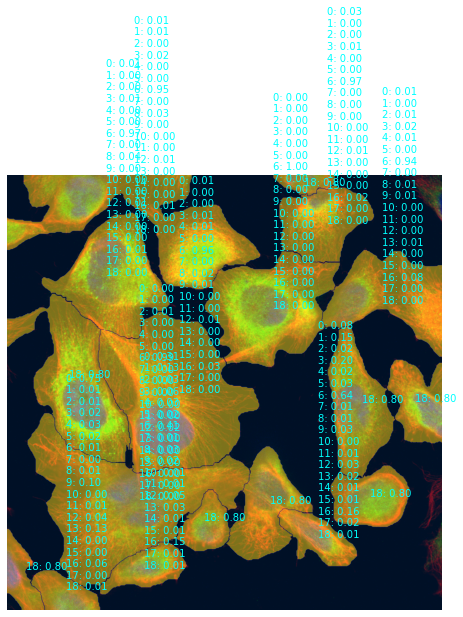

[18] [0.8]


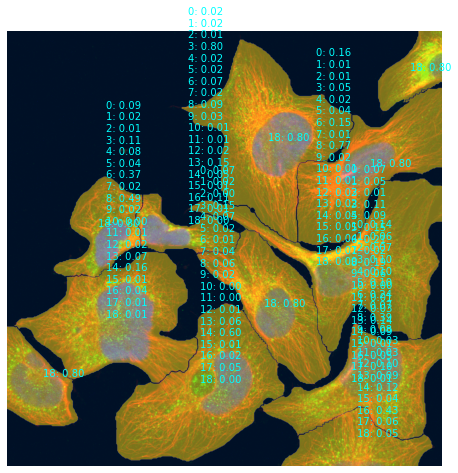


...WORKING ON IMAGE IDS FOR SIZE 2048 ...



  0%|          | 0/1 [00:00<?, ?it/s]


... DEMO IMAGES ...

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [0.20545167 0.04999681 0.07431519 0.10647897 0.10927426 0.13748191
 0.11040287 0.24257922 0.15319748 0.3550052  0.04918603 0.02778026
 0.31808716 0.14169872 0.17365377 0.06615502 0.30126894 0.22429635
 0.07609288]


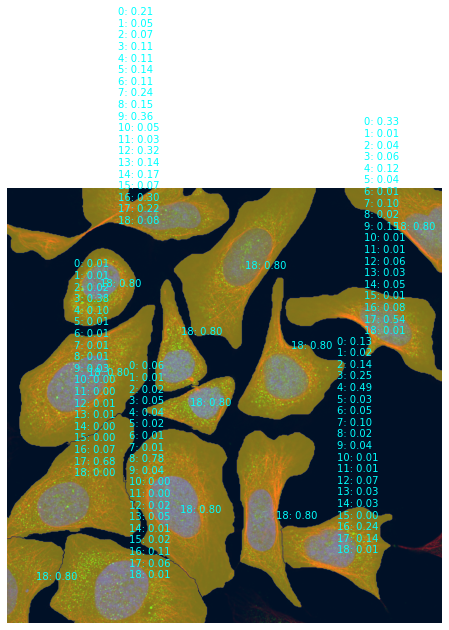

[18] [0.8]


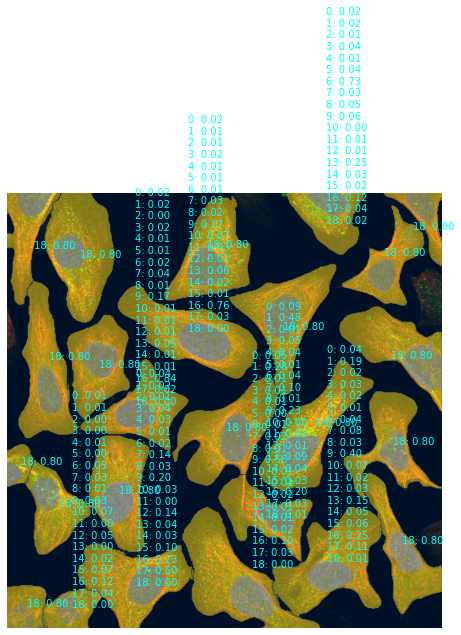


...WORKING ON IMAGE IDS FOR SIZE 3072 ...



  0%|          | 0/1 [00:00<?, ?it/s]


... DEMO IMAGES ...

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [0.00722047 0.00366329 0.00373303 0.01591413 0.00512788 0.00941539
 0.10213914 0.12522955 0.03444002 0.00715049 0.00186436 0.00180884
 0.02974631 0.5024484  0.07592876 0.00685657 0.03495476 0.06451865
 0.00072269]


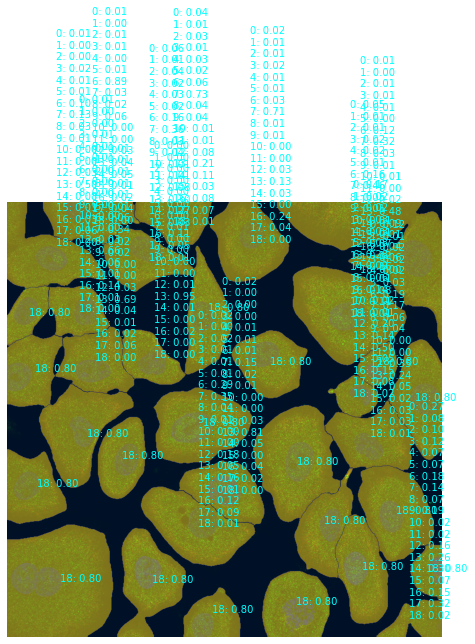

[18] [0.8]


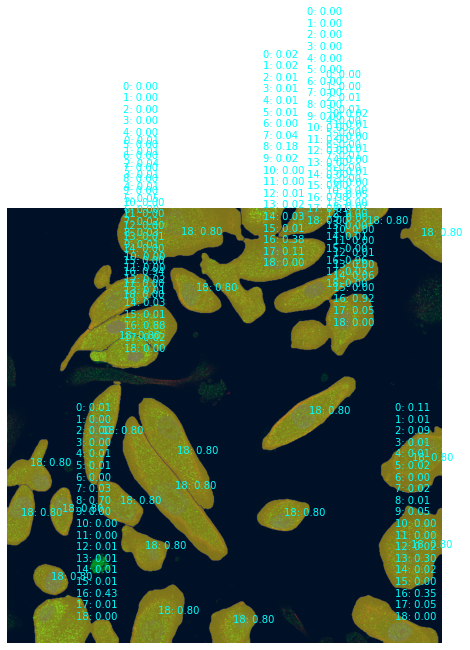


...SKIPPING SIZE 4096 AS THERE ARE NO IMAGE IDS ...


... TEST DATAFRAME ...



,ID,PredictionString
0,020a29cf-2c24-478b-8603-c22a90dc3e31,0 0.0116 eNq1l2l74kYMgP+SZQxsth/bslyW73t8jQ98Y...
1,fea47298-266a-4cf4-93bd-55d1bcc2fc7d,18 0.8000 eNqFUNsOgjAM/aV1XMQ/gOHa4P1BECTGS4L+...
2,0040581b-f1f2-4fbe-b043-b6bfea5404bb,0 0.2055 eNq1Vm2TmjAQ/ksuyfU67fRD+6EzXnABRd5ER...


In [11]:
predictions = []
sub_df = pd.DataFrame(columns=["ID"], 
                      data=predict_ids_1728+predict_ids_2048+predict_ids_3072+predict_ids_4096)

for size_idx, submission_ids in enumerate([predict_ids_1728, predict_ids_2048, 
                                           predict_ids_3072, predict_ids_4096]):
    size = IMAGE_SIZES[size_idx]
    if submission_ids==[]:
        print(f"\n...SKIPPING SIZE {size} AS THERE ARE NO IMAGE IDS ...\n")
        continue
    else:
        print(f"\n...WORKING ON IMAGE IDS FOR SIZE {size} ...\n")
        
    for i in tqdm(range(0, len(submission_ids), BATCH_SIZE), 
                  total=int(np.ceil(len(submission_ids)/BATCH_SIZE))):
 
        batch_rgby_images = [load_image(ID, TEST_IMG_DIR, testing=True, only_public=False)
                             for ID in submission_ids[i:(i+BATCH_SIZE)]]
        batch_rgb_images = [rgby_image.transpose(1,2,0)[..., :-1] for rgby_image in batch_rgby_images]
        
        cell_segmentations = segmentator.pred_cells([[rgby_image[j] for rgby_image in batch_rgby_images] 
                                                     for j in [0, 3, 2]])
        nuc_segmentations = segmentator.pred_nuclei([rgby_image[2] for rgby_image in batch_rgby_images])
        batch_masks = [label_cell(nuc_seg, cell_seg)[1].astype(np.uint8) 
                       for nuc_seg, cell_seg in zip(nuc_segmentations, cell_segmentations)]

        batch_cell_bboxes = [get_contour_bbox_from_raw(mask) for mask in batch_masks]
        submission_rles = [[binary_mask_to_ascii(mask, mask_val=cell_id) for cell_id in range(1, mask.max()+1)] 
                           for mask in batch_masks]
    
        batch_cell_tiles_rgby = [
            [cv2.resize(
                pad_to_square(rgby_image.transpose(1, 2, 0)[bbox[1]:bbox[3], bbox[0]:bbox[2], ...]), 
                TILE_SIZE, interpolation=cv2.INTER_CUBIC) for bbox in bboxes]
            for bboxes, rgby_image in zip(batch_cell_bboxes, batch_rgby_images)]
        
        if augment_list:
            tta_batch_cell_tiles_rgby = [[[torch.from_numpy(tfm(ct) / 255).type(torch.float32) for ct in cts] 
                                          for cts in batch_cell_tiles_rgby] for tfm in augment_list]
            tta_batch_cell_tiles_rgby = [[torch.stack(cts, axis=0).permute(0, 3, 1, 2) 
                                          for cts in batch_cell_tiles_rgby]
                                         for batch_cell_tiles_rgby in tta_batch_cell_tiles_rgby]
            with torch.no_grad():
                tta_batch_o_preds_rgby = [[F.sigmoid(model(cts.to(DEVICE))).cpu().numpy() 
                                           for cts in batch_cell_tiles_rgby] 
                                          for batch_cell_tiles_rgby in tta_batch_cell_tiles_rgby]
            batch_o_preds_rgby = [np.stack(tta_o_preds_rgby, axis=-1).mean(axis=-1)
                                  for tta_o_preds_rgby in zip(*tta_batch_o_preds_rgby)]
        else:
            batch_cell_tiles_rgby = [[torch.from_numpy(ct / 255).type(torch.float32) for ct in cts] 
                                     for cts in batch_cell_tiles_rgby]
            batch_cell_tiles_rgby = [torch.stack(cts, axis=0).permute(0, 3, 1, 2) 
                                     for cts in batch_cell_tiles_rgby]
            with torch.no_grad():
                batch_o_preds_rgby = [F.sigmoid(model(cts.to(DEVICE))).cpu().numpy() 
                                      for cts in batch_cell_tiles_rgby]


#         batch_cell_tiles = [[
#             cv2.resize(
#                 pad_to_square(
#                     rgb_image[bbox[1]:bbox[3], bbox[0]:bbox[2], ...]), 
#                 TILE_SIZE, interpolation=cv2.INTER_CUBIC) for bbox in bboxes] 
#             for bboxes, rgb_image in zip(batch_cell_bboxes, batch_rgb_images)
#         ]
#         batch_cell_tiles = [tf.cast(ct, dtype=tf.float32) for ct in batch_cell_tiles]
#         batch_o_preds = [inference_model.predict(cell_tiles) for cell_tiles in batch_cell_tiles]
        batch_o_preds = batch_o_preds_rgby[:]
        
        # Step 9: Post-Process
        batch_confs = [[pred[np.where(pred>CONF_THRESH)] for pred in o_preds] for o_preds in batch_o_preds]
        batch_preds = [[np.where(pred>CONF_THRESH)[0] for pred in o_preds] for o_preds in batch_o_preds]

        for j, preds in enumerate(batch_preds):
            for k in range(len(preds)):
                if preds[k].size==0:
                    batch_preds[j][k]=np.array([18,])
                    batch_confs[j][k]=np.array([1-np.max(batch_o_preds[j][k]),])

        for j, cts in enumerate(batch_cell_tiles_rgby):
            for k, ct in enumerate(cts):
#                 print(ct.shape, ct[...,1].max())
                if ct[...,1].max() < 60 / 255:
                    batch_preds[j][k] = np.array([18,])
                    batch_confs[j][k] = np.array([0.8,]) #np.array([1 - np.min(batch_o_preds[j][k]), ])
        
        
        # Optional Viz Step
        if IS_DEMO:
            print("\n... DEMO IMAGES ...\n")
            for rgb_images, masks, bboxes, preds, confs in zip(
                batch_rgb_images, batch_masks, batch_cell_bboxes, batch_preds, batch_confs):
                print(preds[0], confs[0])
                texts = ['\n'.join(f'{p}: {c:.2f}' for p, c in zip(pred, conf)) 
                         for pred, conf in zip(preds, confs)]
                centres = [(0.5*(x0 + x1), 0.5*(y0 + y1)) for x0, y0, x1, y1 in bboxes]
                fig, ax = plt.subplots(figsize=(8, 8))
                bmask_total = masks > 0
                ax = plt_image(ax, rgb_images, bmask=bmask_total, centres=centres, texts=texts)
                ax.axis('off')
                plt.show()
        
        # Step 10: Format Predictions To Create Prediction String Easily
        submission_rles = [flatten_list_of_lists([[m,]*len(p) for m, p in zip(masks, preds)]) 
                           for masks, preds in zip(submission_rles, batch_preds)]
        batch_preds = [flatten_list_of_lists(preds, to_string=True) for preds in batch_preds]
        batch_confs = [[f"{conf:.4f}" for cell_confs in confs for conf in cell_confs] for confs in batch_confs]
        
        # Step 11: Save Predictions to Be Added to Dataframe At The End
        predictions.extend([" ".join(flatten_list_of_lists(zip(*[preds,confs,masks]))) for preds, confs, masks in zip(batch_preds, batch_confs, submission_rles)])
sub_df["PredictionString"] = predictions

print("\n... TEST DATAFRAME ...\n")
display(sub_df.head(3))

In [12]:
ss_df = ss_df.merge(sub_df, how="left", on="ID")
ss_df["PredictionString"] = ss_df.apply(create_pred_col, axis=1)
ss_df = ss_df.drop(columns=["PredictionString_x", "PredictionString_y"])
ss_df.to_csv("/kaggle/working/submission.csv", index=False)
display(ss_df)

,ID,ImageWidth,ImageHeight,PredictionString
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 0.2055 eNq1Vm2TmjAQ/ksuyfU67fRD+6EzXnABRd5ER...
1,0173029a-161d-40ef-af28-2342915b22fb,3072,3072,0 0.0072 eNqVVN16sjAMvqUS9JOnx+PDTUOdTsEW/IMK/...
2,020a29cf-2c24-478b-8603-c22a90dc3e31,1728,1728,0 0.0116 eNq1l2l74kYMgP+SZQxsth/bslyW73t8jQ98Y...
3,fea47298-266a-4cf4-93bd-55d1bcc2fc7d,1728,1728,18 0.8000 eNqFUNsOgjAM/aV1XMQ/gOHa4P1BECTGS4L+...
4,ff069fa2-d948-408e-91b3-034cfea428d1,3072,3072,18 0.8000 eNq9VVlvwjAM/kupE9ghoe1h4mqcsKkr1cTY...
5,ff23eea9-4bbe-42af-a8da-9ae16321fc6d,2048,2048,18 0.8000 eNqdkt2OmzAQhV/JB9IGbbutmnaLtg0D+SEJ...
